In [43]:
import pickle
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from collections import defaultdict
from pdbbind_metadata_processor import PDBBindMetadataProcessor

In [2]:
pdbbind_table = PDBBindMetadataProcessor().get_master_dataframe()

In [14]:
pdbbind_table.head()

,PDB code,resolution,release year_x,-logKd/Ki,Kd/Ki,reference,ligand name,activity_list,sep,value,units,release year_y,Uniprot ID,protein name,active
0,3zzf,2.20,2012,0.40,Ki=400mM //,3zzf.pdf,(NLG),"[mM, =, 400]",=,400000000.0,nM,2012,Q01217,ACETYLGLUTAMATE KINASE,False
1,3gww,2.46,2009,0.45,IC50=355mM //,3gwu.pdf,(SFX),"[mM, =, 355]",=,355000000.0,nM,2009,O67854,TRANSPORTER,False
2,1w8l,1.80,2004,0.49,Ki=320mM //,1w8l.pdf,(1P3),"[mM, =, 320]",=,320000000.0,nM,2004,P62937,PEPTIDYL-PROLYL CIS-TRANS ISOMERASE A,False
3,3fqa,2.35,2009,0.49,IC50=320mM //,3fq7.pdf,(GAB&PMP),"[mM, =, 320]",=,320000000.0,nM,2009,P24630,"GLUTAMATE-1-SEMIALDEHYDE 2,1-AMINOMUTASE",False
4,1zsb,2.00,1996,0.60,Kd=250mM //,1zsb.pdf,(AZM),"[mM, =, 250]",=,250000000.0,nM,1996,P00918,CARBONIC ANHYDRASE 2,False


In [49]:
mol_results_path = 'results/random_split_0_pdbbind/mol_results.p'
with open(mol_results_path, 'rb') as f :
    mol_results = pickle.load(f)

conf_results_path = 'results/random_split_0_pdbbind/conf_results.p'
with open(conf_results_path, 'rb') as f :
    conf_results = pickle.load(f)

In [8]:
smiles_df = pd.read_csv('data/smiles_df.csv', index_col=0)

In [10]:
smiles_df.head()

,smiles,dataset,id,included
0,CC[C@H]1[C@@H](C(=O)N[C@]2(C(=O)NS(=O)(=O)C3(C...,pdbbind,6nzt,False
1,Cc1ccc(NC(=O)N[C@@H](Cc2cc(F)cc(F)c2)C(=O)N[C@...,pdbbind,6pka,False
2,O=c1ncc2c(-c3ccc(F)cc3F)cc(N3CC[NH2+]CC3)cc2n1...,pdbbind,1m7q,True
3,CC(C)C[C@H](NC(=O)[C@H](CC(N)=O)NC(=O)[C@@H](N...,pdbbind,5vwk,False
4,CC(C)C[C@H](NC(=O)[C@H](CC(N)=O)NC(=O)[C@@H](N...,pdbbind,5vwi,False


In [11]:
included_pdb_ids = smiles_df[(smiles_df['included']) & (smiles_df['dataset'] == 'pdbbind')]['id'].unique()

In [15]:
included_table = pdbbind_table[pdbbind_table['PDB code'].isin(included_pdb_ids)]

In [73]:
included_table['Uniprot ID'].value_counts()

P00918    420
P56817    325
P24941    239
------    238
O60885    189
         ... 
O00167      1
Q6DN90      1
P00778      1
Q9Y5A9      1
Q13002      1
Name: Uniprot ID, Length: 2489, dtype: int64

In [77]:
def get_target_mol_results(uniprot_id) :
    all_results = {}
    target_pdb_ids = included_table[included_table['Uniprot ID'] == uniprot_id]['PDB code']
    ligand_smiles = smiles_df[smiles_df['id'].isin(target_pdb_ids)]['smiles'].unique()
    for smiles in ligand_smiles :
        if smiles in mol_results :
            all_results[smiles] = mol_results[smiles]
    return all_results

In [78]:
def group_target_results(all_results) :
    target_results = defaultdict(list)
    for smiles, result in all_results.items() :
        if 'normalized_first_bioactive_rank' in result :
            for key in result.keys() :
                value = result[key]
                if type(value) in [int, float, np.float64] :
                    target_results[key].append(value)
            normalized_first_bioactive_rank_model = result['normalized_first_bioactive_rank']['model']
            target_results['normalized_first_bioactive_rank_model'].append(normalized_first_bioactive_rank_model)
    return target_results

In [75]:
included_table[included_table['protein name'] == 'BETA-SECRETASE 1']

,PDB code,resolution,release year_x,-logKd/Ki,Kd/Ki,reference,ligand name,activity_list,sep,value,units,release year_y,Uniprot ID,protein name,active
301,4zsm,1.96,2015,2.40,IC50~4mM //,4zsm.pdf,(4RW),"[mM, ~, 4]",~,4000000.000,nM,2015,P56817,BETA-SECRETASE 1,False
441,2ohk,2.20,2007,2.70,IC50~2000uM //,2ohk.pdf,(1SQ),"[uM, ~, 2000]",~,2000000.000,nM,2007,P56817,BETA-SECRETASE 1,False
444,3bra,2.30,2008,2.70,Kd=2000uM //,3bra.pdf,(AEF),"[uM, =, 2000]",=,2000000.000,nM,2008,P56817,BETA-SECRETASE 1,False
451,3hvg,2.26,2009,2.70,IC50=2mM //,3hvg.pdf,(EV0),"[mM, =, 2]",=,2000000.000,nM,2009,P56817,BETA-SECRETASE 1,False
552,3udh,1.70,2012,2.85,Kd=1.4mM //,3udh.pdf,(091),"[mM, =, 1.4]",=,1400000.000,nM,2012,P56817,BETA-SECRETASE 1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18667,6pz4,1.85,2019,9.40,IC50=0.0004uM //,6pz4.pdf,(P6J),"[uM, =, 0.0004]",=,0.400,nM,2019,P56817,BETA-SECRETASE 1,True
18741,5uyu,1.90,2017,9.51,IC50=0.31nM //,5uyu.pdf,(8QV),"[nM, =, 0.31]",=,0.310,nM,2017,P56817,BETA-SECRETASE 1,True
18750,2g94,1.86,2006,9.52,Ki=0.3nM //,2g94.pdf,(ZPQ),"[nM, =, 0.3]",=,0.300,nM,2006,P56817,BETA-SECRETASE 1,True
18768,4wtu,1.85,2015,9.52,IC50=0.3nM //,4wtu.pdf,(3UT),"[nM, =, 0.3]",=,0.300,nM,2015,P56817,BETA-SECRETASE 1,True


In [79]:
target_name = 'BETA-SECRETASE 1'
uniprot_id = 'P56817'
all_results = get_target_mol_results(uniprot_id)

In [58]:
len(all_results)

38

In [45]:
target_results.keys()

dict_keys(['n_rotatable_bonds', 'n_heavy_atoms', 'max_sim_to_training', 'n_bioactive', 'n_generated', 'r2_all', 'pearson_all', 'spearman_all', 'r2_gen', 'pearson_gen', 'spearman_gen'])

In [64]:
target_results = defaultdict(list)
for smiles, result in all_results.items() :
    if 'normalized_first_bioactive_rank' in result :
        for key in result.keys() :
            value = result[key]
            if type(value) in [int, float, np.float64] :
                target_results[key].append(value)
        normalized_first_bioactive_rank_model = result['normalized_first_bioactive_rank']['model']
        target_results['normalized_first_bioactive_rank_model'].append(normalized_first_bioactive_rank_model)

<AxesSubplot:>

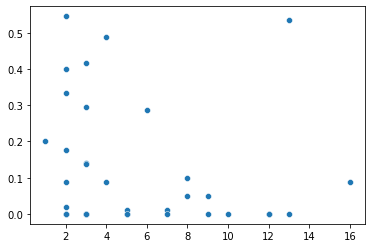

In [65]:
sns.scatterplot(x=target_results['n_rotatable_bonds'],
                y=target_results['normalized_first_bioactive_rank_model'])

<AxesSubplot:>

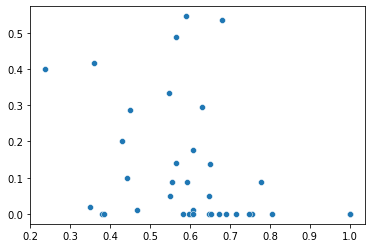

In [67]:
sns.scatterplot(x=target_results['max_sim_to_training'],
                y=target_results['normalized_first_bioactive_rank_model'])

In [87]:
def get_target_name_from_uniprot_id(uniprot_id) :
    if uniprot_id in pdbbind_table['Uniprot ID'].values :
        return pdbbind_table[pdbbind_table['Uniprot ID'] == uniprot_id]['protein name'].value_counts().index[0]
    else :
        print('Uniprot not in PDBbind')
        return None

In [102]:
train_smiles_path = 'data/ligand_random_splits/train_smiles_random_split_0.txt'
with open(train_smiles_path, 'r') as f :
    train_smiles = f.readlines()
    train_smiles = [smiles.strip() for smiles in train_smiles]
def get_training_size(uniprot_id) :
    train_pdb = smiles_df[(smiles_df['smiles'].isin(train_smiles)) 
                          & (smiles_df['dataset'] == 'pdbbind')
                         & (smiles_df['included'])]['id'].unique()
    filtered_table = pdbbind_table[(pdbbind_table['PDB code'].isin(train_pdb)) & (pdbbind_table['Uniprot ID'] == uniprot_id)]
    return len(filtered_table)

In [115]:
target_grouped_results = defaultdict(list)
for uniprot_id in included_table['Uniprot ID'].unique() :
    
    all_results = get_target_mol_results(uniprot_id)
    target_results = group_target_results(all_results)
    
    if len(target_results) :

        ranks = target_results['normalized_first_bioactive_rank_model']
        median = np.median(ranks)
        n_first = len([True for rank in ranks if rank == 0])
        fraction_bioactive_first = n_first / len(ranks)
        target_name = get_target_name_from_uniprot_id(uniprot_id)
        training_set_size = get_training_size(uniprot_id)
        target_grouped_results['uniprot_id'].append(uniprot_id)
        target_grouped_results['name'].append(target_name)
        target_grouped_results['fraction_bio_first'].append(fraction_bioactive_first)
        target_grouped_results['training_set_size'].append(training_set_size)
        target_grouped_results['median_rank'].append(median)
        target_grouped_results['test_set_size'].append(len(ranks))

In [116]:
target_df = pd.DataFrame(target_grouped_results)

In [121]:
target_df

,uniprot_id,name,fraction_bio_first,training_set_size,median_rank,test_set_size
0,Q01217,ACETYLGLUTAMATE KINASE,1.000000,2,0.000000,1
1,O67854,TRANSPORTER,0.666667,27,0.000000,3
2,P62937,PEPTIDYL-PROLYL CIS-TRANS ISOMERASE A,0.000000,10,0.588235,3
3,P00918,CARBONIC ANHYDRASE 2,0.522727,354,0.000000,44
4,P56218,METHIONINE AMINOPEPTIDASE,0.000000,1,0.074074,1
...,...,...,...,...,...,...
965,Q7ZCR0,NL4-3 PROTEASE,1.000000,1,0.000000,1
966,Q9HZ64,PUTATIVE UNCHARACTERIZED PROTEIN,1.000000,1,0.000000,1
967,A2NHM3,ANTIBODY FAB ADD056 HEAVY CHAIN,1.000000,1,0.000000,1
968,O85672,GLUCOAMYLASE,1.000000,1,0.000000,1


In [117]:
target_df['name']

0                     ACETYLGLUTAMATE KINASE
1                                TRANSPORTER
2      PEPTIDYL-PROLYL CIS-TRANS ISOMERASE A
3                       CARBONIC ANHYDRASE 2
4                  METHIONINE AMINOPEPTIDASE
                       ...                  
965                           NL4-3 PROTEASE
966         PUTATIVE UNCHARACTERIZED PROTEIN
967          ANTIBODY FAB ADD056 HEAVY CHAIN
968                             GLUCOAMYLASE
969                                XENAVIDIN
Name: name, Length: 970, dtype: object

In [118]:
xenavidin_uniprot = target_df[target_df['name'] == 'XENAVIDIN']['uniprot_id'].values[0]

In [124]:
xenavidin_pdb = included_table[included_table['Uniprot ID'] == xenavidin_uniprot]['PDB code'].values[0]

In [130]:
xenavidin_smiles = smiles_df[smiles_df['id'] == xenavidin_pdb]['smiles'].values[0]

In [131]:
xenavidin_smiles

'O=C([O-])CCCC[C@@H]1SC[C@@H]2NC(=O)N[C@H]12'

In [135]:
val_smiles_path = 'data/ligand_random_splits/val_smiles_random_split_0.txt'
with open(train_smiles_path, 'r') as f :
    val_smiles = f.readlines()
    val_smiles = [smiles.strip() for smiles in val_smiles]

In [133]:
test_smiles_path = 'data/ligand_random_splits/test_smiles_random_split_0.txt'
with open(train_smiles_path, 'r') as f :
    test_smiles = f.readlines()
    test_smiles = [smiles.strip() for smiles in test_smiles]

In [136]:
xenavidin_smiles in val_smiles

True

<AxesSubplot:xlabel='training_set_size', ylabel='fraction_bio_first'>

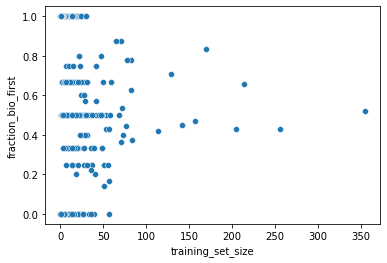

In [120]:
sns.scatterplot(data=target_df, x='training_set_size', y='fraction_bio_first')